# Process the HAM dataset

In [1]:
import pandas as pd
from os import path

In [2]:
base_dir = '/src/dermosxai/data/HAM10000'
segmentation_dir = path.join(base_dir, 'segmentations')
attrs_sheet = path.join(base_dir, 'HAM10000_metadata.csv')

# Read metadata

In [3]:
df = pd.read_csv(attrs_sheet)
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [4]:
print( len(df['lesion_id'].unique()), 'lesions') # some lesions have many images

7470 lesions


## Fix lesions recorded as being in diff locations in different images
Just two lesions with this error: same lesion but wrong location.

In [5]:
reduced_df = df.drop(['image_id', 'dataset'], axis='columns').drop_duplicates() # image id and dataset DO differ between images of the same lesion so ignore those
reduced_df[reduced_df['lesion_id'].duplicated()]

,lesion_id,dx,dx_type,age,sex,localization
2008,HAM_0001726,mel,histo,35.0,female,trunk
2014,HAM_0000871,mel,histo,40.0,female,trunk


In [6]:
df[df['lesion_id'] == 'HAM_0001726']

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
1247,HAM_0001726,ISIC_0029281,mel,histo,35.0,female,back,vidir_modern
1248,HAM_0001726,ISIC_0024367,mel,histo,35.0,female,back,vidir_modern
2008,HAM_0001726,ISIC_0024700,mel,histo,35.0,female,trunk,vidir_molemax


In [7]:
df.loc[2008, 'localization'] = 'back'

In [8]:
df[df['lesion_id'] == 'HAM_0000871']

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
1211,HAM_0000871,ISIC_0025964,mel,histo,40.0,female,chest,vidir_modern
1212,HAM_0000871,ISIC_0030623,mel,histo,40.0,female,chest,vidir_modern
2014,HAM_0000871,ISIC_0026506,mel,histo,40.0,female,trunk,vidir_molemax


In [9]:
df.loc[2014, 'localization'] = 'chest'

## Compute size of lesion in each image using the provided segmentations
When selecting only one image per lesion, we will select the image where it is biggest

In [10]:
from PIL import Image
import numpy as np

In [11]:
mask_paths = df.apply(lambda x: path.join(segmentation_dir, x['image_id']) + '_segmentation.png', axis='columns')
df['lesion_size'] = mask_paths.apply(lambda p: np.array(Image.open(p)).mean()) / 255

In [12]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,lesion_size
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,0.316048
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,0.119726
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,0.267115
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,0.079307
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,0.381237
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,0.543141
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,0.199459
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,0.292774
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,0.507741


# Divide into lesions and images dataframes

In [13]:
lesions = df[['lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization']].drop_duplicates()
images = df[['lesion_id', 'image_id', 'dataset', 'lesion_size']]

### Shuffle
To make sure they are not ordered in any particular way and ease train/val/test splitting later.

In [14]:
# Shuffle lesions
lesions = lesions.sample(frac=1, random_state=1234).reset_index(drop=True)

# Group images so all the images from a lesion are consecutive and the biggest lesion appears first in each group
lesions['order'] = range(len(lesions)) # add auxiliary variable to sort the images
images = pd.merge(images, lesions[['lesion_id', 'order']], on='lesion_id')
images = images.sort_values(['order', 'lesion_size'], ascending=[True, False], ignore_index=True)

# drop auxiliary variable
lesions = lesions.drop('order', axis='columns')
images = images.drop('order', axis='columns')

In [15]:
lesions

,lesion_id,dx,dx_type,age,sex,localization
0,HAM_0003525,nv,histo,60.0,female,trunk
1,HAM_0005982,bcc,histo,70.0,male,lower extremity
2,HAM_0002843,nv,follow_up,40.0,male,hand
3,HAM_0000791,bcc,histo,80.0,male,scalp
4,HAM_0006630,bkl,histo,50.0,male,trunk
...,...,...,...,...,...,...
7465,HAM_0005322,nv,follow_up,45.0,male,trunk
7466,HAM_0005696,nv,consensus,30.0,male,back
7467,HAM_0001791,mel,histo,50.0,female,upper extremity
7468,HAM_0001223,bkl,consensus,75.0,male,trunk


In [16]:
images

,lesion_id,image_id,dataset,lesion_size
0,HAM_0003525,ISIC_0024653,vienna_dias,0.840400
1,HAM_0003525,ISIC_0026141,vienna_dias,0.164107
2,HAM_0005982,ISIC_0031442,vidir_modern,0.341111
3,HAM_0005982,ISIC_0026766,vidir_modern,0.047967
4,HAM_0002843,ISIC_0031855,vidir_molemax,0.022770
...,...,...,...,...
10010,HAM_0005696,ISIC_0025499,vidir_modern,0.113789
10011,HAM_0001791,ISIC_0032504,rosendahl,0.467670
10012,HAM_0001791,ISIC_0027956,rosendahl,0.452104
10013,HAM_0001223,ISIC_0030789,vidir_molemax,0.612830


## Save results

In [17]:
lesions.to_csv(path.join(base_dir, 'lesion_info.csv'), index=False)
images.to_csv(path.join(base_dir, 'image_info.csv'), index=False)

# Create h5 dataset with resized images

In [18]:
from os import path
import pandas as pd
from PIL import Image
import numpy as np

base_dir = '/src/dermosxai/data/HAM10000'
image_dir = path.join(base_dir, 'images')
image_info_path = path.join(base_dir, 'image_info.csv')

In [19]:
image_info = pd.read_csv(image_info_path)
image_paths = image_info.apply(lambda x: path.join(image_dir, x['image_id']) + '.jpg', axis='columns')

# Load and resize to 150 x 200

In [20]:
ims = []
for image_path in image_paths:
    image = Image.open(image_path)
    resized_image = np.array(image.resize((200, 150), resample=Image.LANCZOS, reducing_gap=3))
    ims.append(resized_image)

## Reorder images so we have a list (of size num_patients) of 4-d arrays (num_images_per_patient x 150 x 200 x 3)

In [21]:
idx = 0
grouped_ims = []
for num_images in image_info.groupby('lesion_id', sort=False).size():
    grouped_ims.append(np.stack(ims[idx :idx + num_images]))
    idx += num_images

## Save images

In [22]:
import h5py

with h5py.File(path.join(base_dir, 'images.h5'), 'w') as f:
    for idx, arr in enumerate(grouped_ims):
        dset = f.create_dataset(str(idx), data=arr)

In [2]:
from dermosxai import data
ims, lbls = data.get_HAM10000()

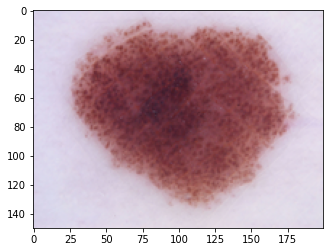

In [30]:
#import matplotlib.pyplot as plt
#plt.imshow(ims[5][0])
plt.imshow(ims[8][0])
#plt.imshow(ims[22][0])

In [31]:
plt.imsave('lesion.png', ims[8][0])

# Create numpy dataset for iGPT

In [30]:
from os import path
import pandas as pd
from PIL import Image
import numpy as np

base_dir = '/src/dermosxai/data/HAM10000'
image_dir = path.join(base_dir, 'images')
segmentation_dir = path.join(base_dir, 'segmentations')
image_info_path = path.join(base_dir, 'image_info.csv')

In [5]:
image_info = pd.read_csv(image_info_path)
image_paths = image_info.apply(lambda x: path.join(image_dir, x['image_id']) + '.jpg', axis='columns')
mask_paths = image_info.apply(lambda x: path.join(segmentation_dir, x['image_id']) + '_segmentation.png', axis='columns')

# Load and resize to 64 x 64

In [81]:
desired_size = (32, 32)

ims = []
for image_path, mask_path in zip(image_paths, mask_paths):
    # Read image and mask
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # Crop a square image using the mask
    (left, up, right, low) = mask.convert('L').getbbox()
    height = low - up
    width = right - left
    if height > width:
        pad_amount = height - width
        left = left - math.floor(pad_amount / 2)
        right = right + math.ceil(pad_amount / 2)
    else:
        pad_amount = width - height
        up = up - math.floor(pad_amount / 2)
        low = low + math.ceil(pad_amount / 2)
    square_image = image.crop((left, up, right, low))
    
    # Resize
    resized_image = np.array(square_image.resize(desired_size, resample=Image.LANCZOS, reducing_gap=3))
    
    # Save
    ims.append(resized_image)

## Reorder images so we have a list (of size num_patients) of 4-d arrays (num_images_per_patient x 150 x 200 x 3)

In [82]:
idx = 0
grouped_ims = []
for num_images in image_info.groupby('lesion_id', sort=False).size():
    grouped_ims.append(np.stack(ims[idx :idx + num_images]))
    idx += num_images

## Save images

In [83]:
good_ims = np.stack(ims[0] for ims in grouped_ims)
np.save(path.join(base_dir, 'square_32_images.npy'), good_ims)